## Projeto de Machine Learning Não Supervisionado

### 1. **Introdução e Contexto do Projeto**
#### Objetivo
O principal objetivo deste projeto é desenvolver e implementar um modelo de machine learning não supervisionado capaz de agrupar textos de notícias em categorias distintas, utilizando o conteúdo textual como base para a análise. Esse modelo buscará identificar padrões e similaridades intrínsecas nos dados para realizar a clusterização efetiva, facilitando a organização e a recuperação de informações específicas dentro de grandes volumes de dados textuais.

#### Importância e Aplicabilidade
O crescente volume de dados textuais gerados diariamente exige técnicas eficazes de processamento e análise. A aplicação de técnicas de processamento de linguagem natural (PLN) para classificar e agrupar automaticamente textos em categorias predefinidas pode melhorar significativamente a eficiência dos processos de busca e recuperação de informação, auxiliando desde a curadoria de conteúdo até a análise de sentimentos e detecção de tendências.

#### Metodologia
Para atingir o objetivo proposto, serão empregadas técnicas avançadas de PLN juntamente com algoritmos de clusterização como KMeans, DBSCAN e Clustering Aglomerativo. A escolha do algoritmo mais adequado será baseada em uma análise comparativa dos scores de Silhouette obtidos, que medem a eficácia da clusterização em termos da coesão interna dos clusters e da separação entre eles. Este indicador será crucial para determinar o modelo mais eficiente para a tarefa de agrupamento.

#### Potenciais Descobertas
Após a aplicação das técnicas de clusterização, espera-se identificar grupos claros de artigos que compartilhem temáticas ou estilos similares, refletindo a diversidade e a riqueza do conjunto de dados analisado. Além disso, a análise dos clusters poderá revelar insights sobre as tendências predominantes nos dados, auxiliando na compreensão de padrões e na geração de novos conhecimentos a partir do corpus textual.

Essa abordagem não apenas proporcionará uma visão estruturada do conjunto de dados mas também servirá como base para futuras pesquisas e aplicações que dependam da categorização automática e eficiente de textos em diversos contextos, como jornalismo digital, monitoramento de mídias sociais e sistemas de recomendação.


### 2. **Instalação e importação de bibliotecas**

#### Primeiro, você precisa instalar o spaCy e o modelo de língua portuguesa.

In [22]:
# !pip install spacy -q
# !python -m spacy download pt_core_news_sm

#### Importa todas as bibliotecas necessárias para o projeto.

In [2]:
from typing import Any
from typing import Iterator
from scipy.sparse import csr_matrix

import json
import numpy as np
import pandas as pd
import spacy
import scipy

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.express as px

#### Carregar o modelo de língua portuguesa do spaCy

In [3]:
nlp = spacy.load("pt_core_news_sm")

### 3. **Leitura dos Dados**
#### Carregamento e visualização inicial dos dados para entender a estrutura e o tipo de informação disponível.

In [4]:
def read_json(file_path: str) -> Iterator[tuple[int, dict[str, Any]]]:
    """
    Lê um único objeto JSON de um arquivo.

    Retorna um gerador que yielding a pair (index, json_obj), onde:
        - index: o índice do objeto no arquivo JSON (se for um array)
        - json_obj: o objeto JSON correspondente

    Se o arquivo for um objeto JSON único (não um array), o gerador yielding apenas uma vez com o índice 0.

    Se há erros ao decodificar o JSON, imprime uma mensagem de erro e ignora o arquivo.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            json_obj = json.load(f)
            if isinstance(json_obj, list):  # É um array JSON
                for index, item in enumerate(json_obj):
                    yield index, item
            else:
                yield 0, json_obj  # Objeto JSON único
        except json.JSONDecodeError as e:
            print(f"Erro ao decodificar JSON: {e}")


#### Carregar Dados do Arquivo JSON

In [40]:
# Define o caminho para o arquivo JSON contendo os artigos
file_path = '/opt/services/poc-Unsupervised-ML/notebooks/dataset/PortugueseNewsDataset/content/json/wikinews_categories.json'

# Utiliza a função read_json para ler dados do arquivo JSON especificado
reader = read_json(file_path)

# Cria uma lista de dicionários onde cada dicionário representa um artigo,
# iterando sobre cada objeto JSON retornado pelo gerador read_json
all_articles = [article_dict for index, article_dict in read_json(file_path)]

### Carregar os Dados em um DataFrame e Exibir Informações

# Converte a lista de artigos em um DataFrame do pandas para facilitar a manipulação e análise dos dados
df = pd.DataFrame(all_articles)

# Exibe informações sobre o DataFrame, como o número de linhas e colunas, tipos de dados e memória utilizada
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9135 entries, 0 to 9134
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pageid    9135 non-null   object
 1   title     9135 non-null   object
 2   dates     9135 non-null   object
 3   body      9135 non-null   object
 4   category  9135 non-null   object
dtypes: object(5)
memory usage: 357.0+ KB


### 4. **Pre-processamento de Texto**

#### Lista com Stopwords para Remoção no Pré-processamento

In [28]:
# Define uma lista expandida de stopwords. Estas são palavras frequentes que geralmente não contribuem
# para o significado do texto e são removidas antes da análise.
stopwords_expandidas = set([
    "de", "a", "o", "que", "e", "do", "da", "em", "um", "para", "é", "com", "não", "uma", "os", "no", "se", "na", "por", 
    "mais", "as", "dos", "como", "mas", "foi", "ao", "ele", "das", "tem", "à", "seu", "sua", "ou", "ser", "quando", 
    "muito", "nos", "já", "eu", "também", "só", "pelo", "pela", "até", "isso", "ela", "entre", "era", "depois", 
    "sem", "mesmo", "aos", "ter", "seus", "quem", "nas", "me", "esse", "eles", "estão", "você", "tinha", "foram", 
    "essa", "num", "nem", "suas", "meu", "às", "minha", "têm", "numa", "pelos", "elas", "havia", "seja", "qual", 
    "será", "nós", "tenho", "lhe", "deles", "essas", "esses", "pelas", "este", "fosse", "dele", "tu", "te", 
    "vocês", "vos", "lhes", "meus", "minhas", "teu", "tua", "teus", "tuas", "nosso", "nossa", "nossos", "nossas",
    "dela", "delas", "esta", "estes", "estas", "aquele", "aquela", "aqueles", "aquelas", "isto", "aquilo", "estou", 
    "está", "estamos", "estão", "estive", "esteve", "estivemos", "estiveram", "estava", "estávamos", "estavam", 
    "estivera", "estivéramos", "esteja", "estejamos", "estejam", "estivesse", "estivéssemos", "estivessem", 
    "estiver", "estivermos", "estiverem", "hei", "há", "havemos", "hão", "houve", "houvemos", "houveram", 
    "houvera", "houvéramos", "haja", "hajamos", "hajam", "houvesse", "houvéssemos", "houvessem", "houver", 
    "houvermos", "houverem", "houverei", "houverá", "houveremos", "houverão", "houveria", "houveríamos", 
    "houveriam", "sou", "somos", "são", "era", "éramos", "eram", "fui", "foi", "fomos", "foram", "fora", 
    "fôramos", "seja", "sejamos", "sejam", "fosse", "fôssemos", "fossem", "for", "formos", "forem", "serei", 
    "será", "seremos", "serão", "seria", "seríamos", "seriam", "tenho", "tem", "temos", "tém", "tinha", "tínhamos", 
    "tinham", "tive", "teve", "tivemos", "tiveram", "tivera", "tivéramos", "tenha", "tenhamos", "tenham", "tivesse", 
    "tivéssemos", "tivessem", "tiver", "tivermos", "tiverem", "terei", "terá", "teremos", "terão", "teria", 
    "teríamos", "teriam"
]) #"ano", "dizer", "14", "15", "12", "10"


#### Funções para limpeza e preparação dos textos.

In [29]:
def preprocess_text(text: str) -> str:
    """
    Realiza o pré-processamento do texto usando spaCy, incluindo lematização e remoção de stopwords.

    O pré-processamento inclui:

    1. Convertendo o texto para letras minúsculas;
    2. Removendo stopwords;
    3. Removendo pontuações;
    4. Lematizando cada palavra.

    Parameters
    ----------
    text : str
        Texto original a ser processado.

    Returns
    -------
    str
        Texto pré-processado.
    """
    # Carrega o modelo de língua portuguesa do spaCy
    doc = nlp(text.lower())
    # Cria uma lista com as palavras do texto, sem stopwords e sem pontuações
    result = [
        token.lemma_
        for token in doc
        if token.text not in stopwords_expandidas and not token.is_punct
    ]
    # Retorna o texto pré-processado, concatenando todas as palavras na string
    return " ".join(result)


#### Aplicando o pré-processamento

In [9]:
# %%time
df['cleaned_body'] = df['body'].apply(preprocess_text)

/bin/bash: linha 1: fg: nenhum controle de trabalho


### 5. **Vetorização dos Textos**
#### Transformação dos textos em uma matriz numérica usando TF-IDF.

- **TF-IDF (Term Frequency-Inverse Document Frequency)**: Esta técnica é usada para converter textos em uma matriz de características numéricas. TF-IDF é uma estatística numérica que destaca a importância de uma palavra para um documento em relação a uma coleção de documentos ou corpus. O valor TF-IDF aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensado pelo número de documentos que contêm a palavra, o que ajuda a ajustar o fato de que algumas palavras aparecem com mais frequência em geral. 

In [24]:
def vectorize_texts(
    texts: list[str],
) -> tuple[csr_matrix, list[str]]:
    """
    Converte uma lista de textos pré-processados em uma matriz TF-IDF.

    Parâmetros
    ----------
    texts : list
        Lista de textos a serem vetorizados.

    Retorna
    -------
    tuple
        Uma tupla contendo a matriz TF-IDF e uma lista de nomes de
        características. Os nomes de características correspondem às
        palavras do vocabulário do vetorizador TF-IDF.
    """
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix, vectorizer.get_feature_names_out()


#### Vetorização dos textos processados

In [11]:
tfidf_matrix, features = vectorize_texts(df["cleaned_body"].tolist())

#### Extrai as palavras-chave principais para cada documento com base nas pontuações TF-IDF mais altas.

In [12]:
def extract_keywords(
    tfidf_matrix: scipy.sparse.csr_matrix,
    features: list[str],
    top_n: int = 3,
) -> list[list[str]]:
    """
    Extrai as palavras-chave principais para cada documento com base nas pontuações TF-IDF mais altas.

    Parameters
    ----------
    tfidf_matrix : scipy.sparse.csr_matrix
        Matriz TF-IDF dos documentos.
    features : list
        Lista de todos os termos ou "features" no vocabulário TF-IDF.
    top_n : int
        Número de palavras-chave mais relevantes a serem retornadas para cada documento.

    Returns
    -------
    list
        Lista contendo as palavras-chave mais relevantes para cada documento.
    """
    # Itera sobre cada linha da matriz TF-IDF
    top_keywords = []
    for row in tfidf_matrix:
        # Converte a linha da matriz TF-IDF para um array denso e obtém os índices dos maiores valores
        # (com base nas pontuações TF-IDF)
        sorted_indices = row.toarray().flatten().argsort()[-top_n:]
        # Extrai as palavras-chave mais relevantes (top-n) para cada documento
        top_keywords.append([features[idx] for idx in sorted_indices][::-1])

    # Retorna a lista de palavras-chave mais relevantes para cada documento,
    # separadas por vírgulas e espaços
    return ["; ".join(keywords) for keywords in top_keywords]


### 6. **Aplicação de Técnicas de Clustering**
#### Avaliação de Diferentes Algoritmos de Clustering

Aplicamos múltiplos algoritmos de clustering, incluindo KMeans, DBSCAN e Agglomerative Clustering, para explorar qual técnica oferece a melhor segmentação dos dados. 
Cada algoritmo é avaliado com base em sua capacidade de formar clusters claramente distintos, o que é quantificado através do cálculo do Silhouette Score.

In [31]:
def apply_clustering(
    tfidf_matrix: scipy.sparse.csr_matrix,
    n_clusters: int = 8,
) -> dict:
    """
    Aplica múltiplos algoritmos de clusterização na matriz TF-IDF.

    Parameters
    ----------
    tfidf_matrix : scipy.sparse.csr_matrix
        Matriz TF-IDF dos documentos.
    n_clusters : int
        Número de clusters desejados (não aplicável para DBSCAN).

    Returns
    -------
    dict
        Dicionário com labels dos clusters e scores de Silhouette para cada algoritmo.
    """
    # Define os algoritmos de clusterização a serem utilizados
    algorithms = {
        "KMeans": KMeans(n_clusters=n_clusters, random_state=42),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    }

    # Armazena os resultados dos algoritmos em um dicionário
    results = {}
    for name, model in algorithms.items():
        # Converte a matriz TF-IDF para um array denso se o algoritmo
        # for o Agglomerative
        data = (
            tfidf_matrix.toarray() if name == "Agglomerative" else tfidf_matrix
        )

        # Executa o algoritmo de clusterização e obtém as labels dos
        # clusters
        labels = model.fit_predict(data)

        # Calcula o score de Silhouette se o algoritmo for um que
        # implemente este cálculo
        if len(set(labels)) > 1 and len(set(labels)) < len(labels):
            # Cálculo do score de Silhouette
            silhouette_avg = silhouette_score(data, labels)
        else:
            # Nenhum score de Silhouette disponível
            silhouette_avg = -1

        # Armazena os resultados do algoritmo no dicionário
        results[name] = {"labels": labels, "score": silhouette_avg}

    return results

clustering_results = apply_clustering(tfidf_matrix)

/opt/services/poc-Unsupervised-ML/poc-ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/services/poc-Unsupervised-ML/poc-ml/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul



In [37]:
def plot_algorithms(names: list[str], scores: list[float]) -> None:
    """
    Plota um gráfico de barras com os Silhouette scores para cada
    algoritmo de clustering.

    Parameters
    ----------
    names : List[str]
        Lista com os nomes dos algoritmos de clustering.
    scores : List[float]
        Lista com os Silhouette scores para cada algoritmo.

    Returns
    -------
    None
    """
    # Criando o gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(names, scores, color=["blue", "green", "red"])
    ax.set_xlabel("Algoritmos de Clustering")
    ax.set_ylabel("Silhouette Score")
    ax.set_title("Comparação dos Silhouette scores para Algoritmos de Clustering")
    # Ajuste do limite do eixo y para melhor visualização
    ax.set_ylim([min(scores) - 0.1, 1])
    plt.show()


#### Comparação do Desempenho dos Algoritmos
- **Silhouette Score**: Uma métrica usada para avaliar a qualidade dos clusters formados por diferentes algoritmos de clustering. O Silhouette Score varia de -1 a +1, onde um valor alto indica que os clusters são bem compactos internamente e bem separados uns dos outros. 

KMeans: 0.0848
Descrição: K-Means é um algoritmo de clustering que particiona os dados em K clusters, atribuindo cada ponto ao centroide mais próximo.

DBSCAN: -0.0101
Descrição: DBSCAN é um algoritmo baseado em densidade que pode formar clusters de formas complexas, baseando-se em densidade de pontos.

Agglomerative: 0.0870
Descrição: Clustering Aglomerativo é uma abordagem hierárquica que funde progressivamente os pares de clusters até que todos os clusters tenham sido combinados em um.



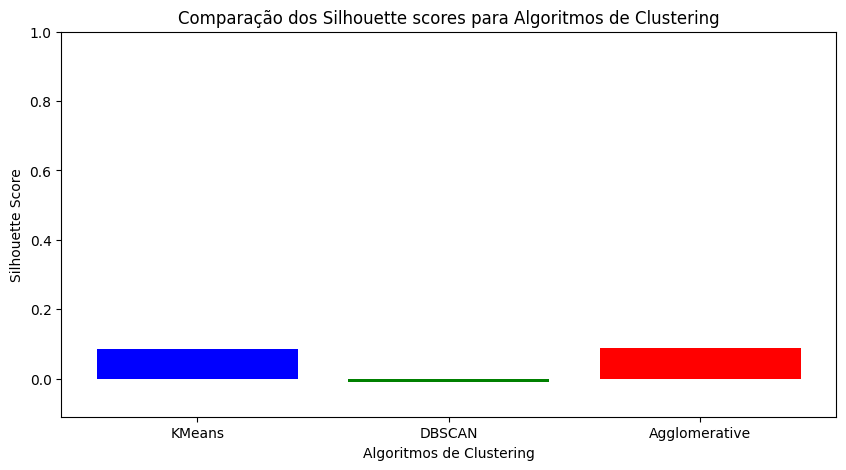

In [41]:
algorithms = {
    "KMeans": "K-Means é um algoritmo de clustering que particiona os dados em K clusters, atribuindo cada ponto ao centroide mais próximo.",
    "DBSCAN": "DBSCAN é um algoritmo baseado em densidade que pode formar clusters de formas complexas, baseando-se em densidade de pontos.",
    "Agglomerative": "Clustering Aglomerativo é uma abordagem hierárquica que funde progressivamente os pares de clusters até que todos os clusters tenham sido combinados em um.",
}

# Exibindo os resultados e descrições
for name, details in algorithms.items():
    score = clustering_results[name]["score"]
    print(f"{name}: {score:.4f}")
    print(f"Descrição: {details}\n")

# Clustering_results definido com 'labels' e 'score' para cada algoritmo
names = list(algorithms.keys())
scores = [clustering_results[name]["score"] for name in names]

plot_algorithms(names, scores)

In [39]:
best_algorithm = max(
    clustering_results, key=lambda x: clustering_results[x]["score"]
)
print(
    f"Melhor algoritmo baseado no Silhouette Score: {best_algorithm}"
)

Melhor algoritmo baseado no Silhouette Score: Agglomerative


In [33]:
def plot_feature_importances(
    features: list[str], tfidf_matrix: scipy.sparse.csr_matrix
) -> None:
    """
    Plota a importância das features baseada nas pontuações TF-IDF médias.

    Parâmetros
    ----------
    features : List[str]
        Lista de nomes das features (palavras) do vetorizador TF-IDF.
    tfidf_matrix : scipy.sparse.csr_matrix
        Matriz TF-IDF dos documentos.

    Retorna
    -------
    None
    """
    # Certifique-se de que a matriz TF-IDF est  em formato denso para cálculo da média
    if not isinstance(tfidf_matrix, np.ndarray):
        tfidf_matrix = tfidf_matrix.toarray()

    feature_importances = np.mean(
        tfidf_matrix, axis=0
    )  # Média por coluna para importância
    df_features = pd.DataFrame(
        {"Feature": features, "Importance": feature_importances}
    )
    df_features = df_features.sort_values(
        by="Importance", ascending=False
    ).head(20)

    # Plota o gráfico de barras
    fig = px.bar(
        df_features,
        x="Importance",
        y="Feature",
        orientation="h",
        title="Top 20 Features by TF-IDF Importance",
    )
    fig.show()


#### Plotagem das importâncias das features e dos clusters

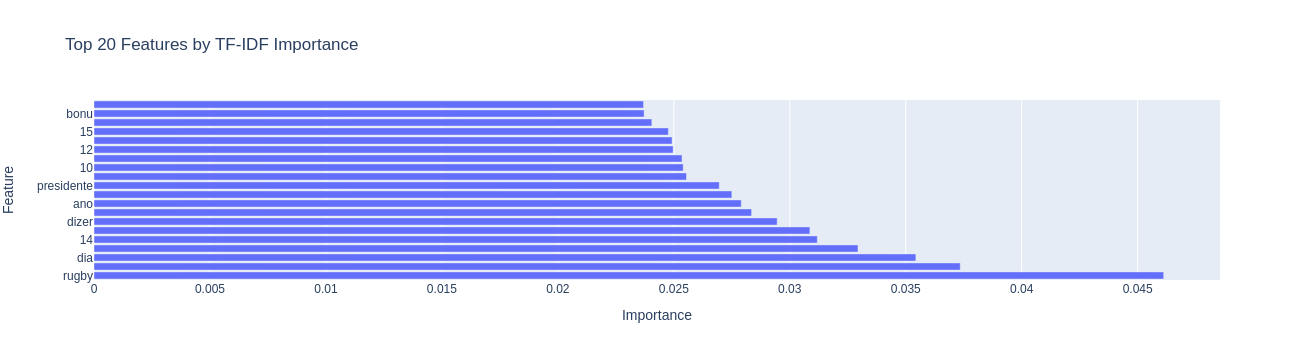

In [34]:
plot_feature_importances(features, tfidf_matrix)

...

### 7. **Análise e Visualização dos Resultados**
#### Visualização dos clusters usando t-SNE e Plotly para uma interpretação interativa.

In [25]:
def apply_tsne(data, n_components=2, random_state=42):
    """
    Aplica t-SNE para redução de dimensionalidade nos dados fornecidos.

    Parameters
    ----------
    data : array-like
        Dados de alta dimensionalidade a serem transformados.
    n_components : int, default=2
        Número de componentes desejados para a saída.
    random_state : int, default=42
        Semente de aleatoriedade para reprodução dos resultados.

    Returns
    -------
    DataFrame
        DataFrame com os componentes resultantes do t-SNE.
    """
    print("apply_tsne function started")
    tsne = TSNE(n_components=n_components, random_state=random_state)
    print("Created t-SNE object")
    tsne_results = tsne.fit_transform(data)
    print("Computed t-SNE results")
    return pd.DataFrame(tsne_results, columns=["Componente 1", "Componente 2"])
    print("Created DataFrame with t-SNE results")


In [26]:
def plot_clusters(df_tsne: pd.DataFrame) -> None:
    """
    Plota os clusters utilizando a técnica de t-Distributed Stochastic Neighbor Embedding (t-SNE)
    e usando uma paleta de cores customizada.

    Parameters
    ----------
    df_tsne : pd.DataFrame
        DataFrame contendo os resultados do t-SNE e metadados dos clusters.

    Returns
    -------
    None
        Nenhum valor é retornado. A figura com a visualização dos clusters
        é exibida na saída padr o.
    """
    # Define a paleta de cores customizada
    custom_colors = [
        "#e6194b",  # Vermelho
        "#3cb44b",  # Verde
        "#ffe119",  # Amarelo
        "#4363d8",  # Azul
        "#f58231",  # Laranja
        "#911eb4",  # Roxo
        "#46f0f0",  # Ciano
        "#f032e6",  # Magenta
    ]

    # Cria a figura com a visualização dos clusters
    fig = px.scatter(
        df_tsne,
        x="Componente 1",  # Componente 1 do t-SNE
        y="Componente 2",  # Componente 2 do t-SNE
        color="Cluster",  # Atributo Cluster como cor
        color_discrete_sequence=custom_colors,  # Paleta de cores customizada
        title="Visualiza o dos Clusters com t-SNE",  # Título da figura
        hover_data=["Categoria", "Palavras-chave"],  # Atributos para o hover
    )

    # Ajusta a configuração da figura
    fig.update_traces(
        marker=dict(
            size=10,  # Tamanho dos marcadores
            opacity=0.7,  # Opacidade dos marcadores
            line=dict(
                width=2, color=custom_colors
            ),  # Linha ao redor dos marcadores
        )
    )

    fig.update_layout(
        width=1000,  # Largura da figura
        height=800,  # Altura da figura
        legend_title_text="Cluster",  # T tulo da legenda
    )

    fig.show()


#### Usando o melhor algoritmo para visualização com t-SNE

apply_tsne function started
Created t-SNE object
Computed t-SNE results


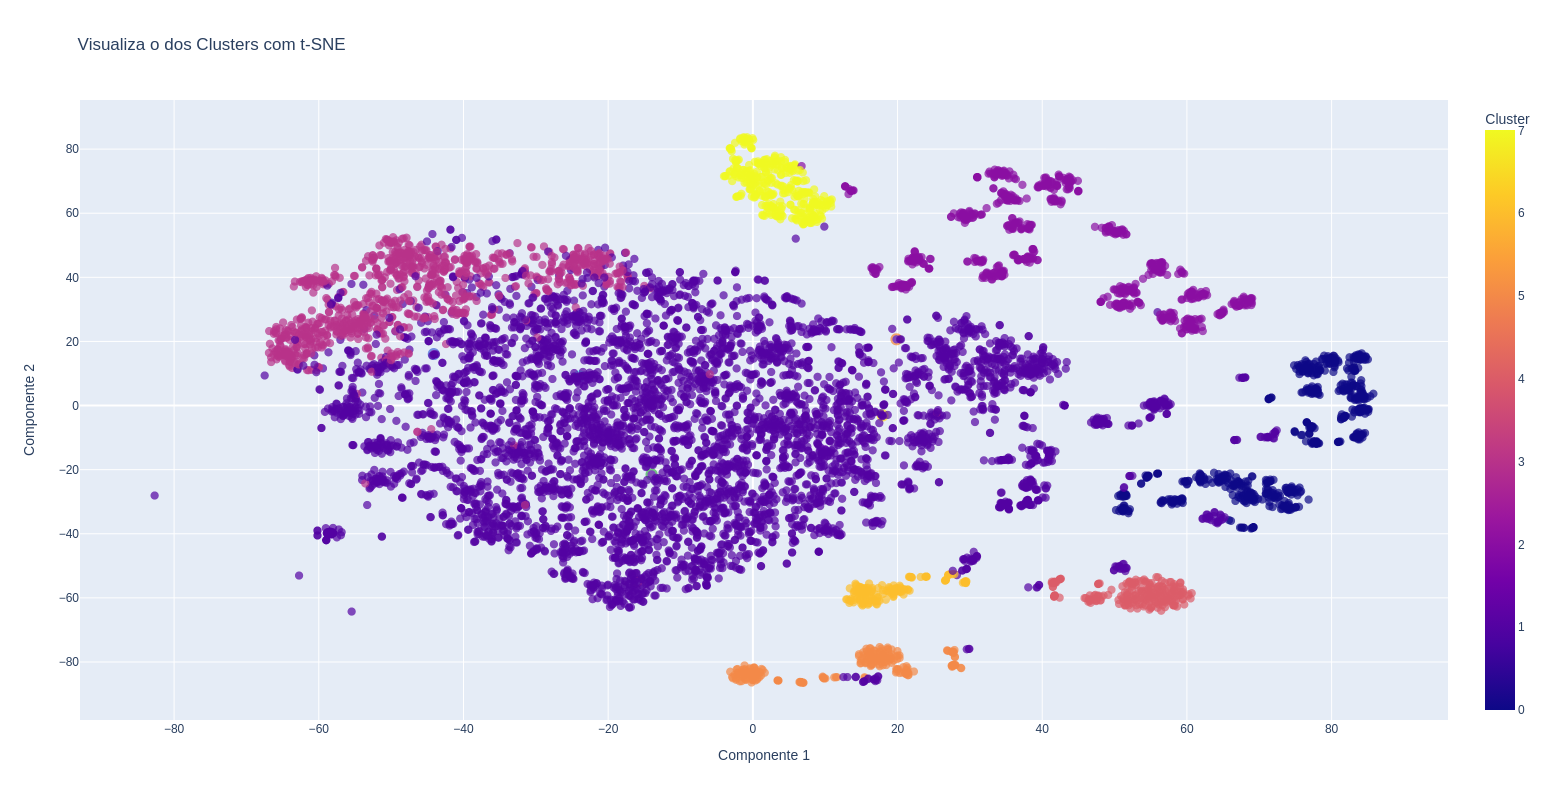

In [21]:
df_tsne = apply_tsne(tfidf_matrix.toarray())
df_tsne["Cluster"] = clustering_results[best_algorithm]["labels"]
df_tsne["Categoria"] = df["category"].tolist()
df_tsne["Palavras-chave"] = extract_keywords(tfidf_matrix, features)


plot_clusters(df_tsne)

### 8. **Conclusão**

**Após a análise e visualização dos resultados dos clusters, é importante resumir os achados, destacando como os dados foram agrupados e o significado prático desses agrupamentos. Aqui também discutimos a eficácia dos métodos de clustering utilizados.**

```markdown
A aplicação de técnicas de clustering no conjunto de dados de textos processados revelou padrões interessantes e agrupamentos claros, conforme indicado pelos scores de Silhouette. Os resultados obtidos com o K-Means, por exemplo, mostraram uma segmentação eficiente em certas categorias de texto, o que pode ser extremamente útil para tarefas de organização automática de conteúdo ou para a criação de sistemas de recomendação baseados em texto.

Os scores de Silhouette ajudaram a validar a consistência interna dos clusters formados, embora algumas técnicas, como o DBSCAN, tenham mostrado limitações devido à densidade variável dos dados. A visualização com t-SNE ofereceu uma representação gráfica intuitiva dos clusters, facilitando a interpretação dos resultados.
```

### 9. **Direções Futuras**

**Discussão sobre as melhorias que podem ser implementadas, novos dados que podem ser explorados, ou técnicas adicionais de análise que poderiam ser aplicadas para enriquecer ainda mais o projeto.**

#### Para futuras iterações deste projeto, várias melhorias podem ser consideradas:

1. **Exploração de Mais Dados**: Incluir um conjunto de dados mais amplo ou diversificado pode ajudar a melhorar a robustez dos modelos de clustering e permitir a descoberta de mais padrões únicos.
2. **Utilização de Modelos de PLN Avançados**: Implementar modelos de linguagem mais avançados como BERT ou GPT para pré-processamento de texto poderia melhorar a qualidade das features extraídas e, por consequência, a qualidade dos clusters.
3. **Otimização de Hiperparâmetros**: Realizar uma busca mais sistemática de hiperparâmetros para os algoritmos de clustering poderia levar a resultados ainda melhores.
4. **Análise de Sentimentos**: Integrar análise de sentimentos nos textos pode adicionar uma camada adicional de interpretação aos clusters, especialmente útil em domínios como análise de feedback de clientes ou redes sociais.
5. **Implementação de Clustering Hierárquico**: Experimentar com clustering hierárquico para uma visão em diferentes níveis de granularidade dos dados.


### 10. Referências e Recursos Utilizados

1. **Introdução ao Processamento de Linguagem Natural (PLN)**:
   - [Natural Language Processing with Python](https://www.nltk.org/book/) – Livro que oferece uma introdução prática ao PLN usando Python e a biblioteca NLTK.

2. **Uso de spaCy para Análise de Texto**:
   - [spaCy 101: Everything you need to know](https://spacy.io/usage/spacy-101) – Guia oficial que explica os conceitos fundamentais da biblioteca spaCy para PLN.

3. **Técnicas de Vetorização de Texto – TF-IDF**:
   - [TfidfVectorizer – Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) – Documentação oficial do Scikit-learn sobre o uso de TF-IDF para vetorização de texto.

4. **Métodos de Clustering e Suas Aplicações**:
   - [Scikit-learn Clustering Techniques](https://scikit-learn.org/stable/modules/clustering.html) – Uma revisão detalhada dos diferentes métodos de clustering disponíveis no Scikit-learn.
   - [DBSCAN Clustering Algorithm: Tutorial and Example](https://towardsdatascience.com/dbscan-clustering-algorithm-what-is-it-when-to-use-it-how-dbscan-works-47b8e8926b6b) – Artigo que fornece uma visão geral do algoritmo DBSCAN e suas aplicações.

5. **Uso de Silhouette Score para Avaliação de Clusters**:
   - [Silhouette Score – Scikit-learn Documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) – Guia sobre como calcular e interpretar o Silhouette Score para avaliação de clusters.

6. **Redução de Dimensionalidade com t-SNE**:
   - [Visualizing Data using t-SNE – Journal of Machine Learning Research](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) – Artigo seminal que introduz a técnica de t-SNE para visualização de dados de alta dimensão.

7. **Guias de Boas Práticas em Machine Learning**:
   - [Google Machine Learning Guides](https://developers.google.com/machine-learning/guides) – Coleção de guias e melhores práticas para desenvolvimento de soluções de machine learning.

8. **Construção e Avaliação de Modelos de Machine Learning**:
   - [Building and Evaluating Models – Machine Learning Mastery](https://machinelearningmastery.com/) – Blog que oferece tutoriais detalhados sobre a construção e avaliação de modelos de machine learning.

9. **Plotly para Visualização de Dados Interativa**:
   - [Plotly Python Graphing Library](https://plotly.com/python/) – Documentação oficial da biblioteca Plotly para Python, útil para criação de visualizações interativas de dados.

10. **Artigos Científicos e Conferências de PLN**:
    - [Association for Computational Linguistics (ACL) Anthology](https://aclanthology.org/) – Um repositório digital de artigos sobre pesquisa em linguística computacional e PLN.
